In [1]:
from seisray.core.earth_models import EarthModelManager
from seisray.core.ray_paths import RayPathTracer
from seisray.visualization.earth_plots import EarthPlotter
from seisray.visualization.earth_3d import Earth3DVisualizer
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('trame')  # Interactive backend for Jupyter

### Plotting the 1D Earth model

You can visualize the 1D profiles (e.g., Vp and Vs vs. depth) for any TauP model using `EarthModelManager.plot_1d_profile()`. The example below plots Vp and Vs for `iasp91` down to 700 km depth.

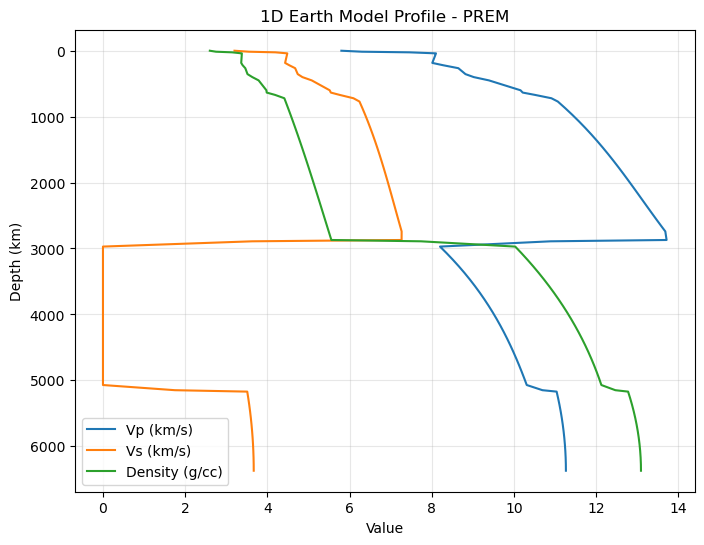

In [2]:
# Visualize 1D Earth model profiles (Vp, Vs) for iasp91
emm = EarthModelManager()
emm.plot_1d_profile('prem', properties=['vp','vs', 'rho'], max_depth_km=6371)
plt.show()

In [13]:
# Example: Geographic coordinates (Realistic seismic scenario)
source_lat, source_lon = 0, 0       # Source at equator, 0° longitude
source_depth_km = 10.0               # 10 km depth
receiver_lat, receiver_lon = 0, 60  # 60 degrees away

tracer = RayPathTracer(model_name='prem')

# Get ray paths using geographic coordinates - REQUEST MULTIPLE PHASES
ray_paths, geo_info = tracer.get_ray_paths(
    source_lat=source_lat,
    source_lon=source_lon,
    source_depth=source_depth_km,
    receiver_lat=receiver_lat,
    receiver_lon=receiver_lon,
    phases=['P', 'PP', 'S', 'SS']   # Multiple phases for testing
)

print(f"📏 Distance: {geo_info['distance_deg']:.1f}° ({geo_info['distance_km']:.0f}km)")
print(f"📐 Azimuth: {geo_info['azimuth']:.1f}°")
print(f"🌊 Ray paths found: {len(ray_paths)}")

# Show details for ALL ray paths found
for i, ray in enumerate(ray_paths):
    print(f"\n--- Ray {i+1} ---")
    print(f"⏱️  Travel time: {ray.time:.1f} seconds")
    print(f"🎯 Phase: {ray.name}")
    print(f"📊 Ray path points: {len(ray.path['depth'])}")
    print(f"🏔️  Maximum depth: {max(ray.path['depth']):.1f} km")

📏 Distance: 60.0° (6679km)
📐 Azimuth: 90.0°
🌊 Ray paths found: 12

--- Ray 1 ---
⏱️  Travel time: 605.5 seconds
🎯 Phase: P
📊 Ray path points: 272
🏔️  Maximum depth: 1554.3 km

--- Ray 2 ---
⏱️  Travel time: 737.6 seconds
🎯 Phase: PP
📊 Ray path points: 340
🏔️  Maximum depth: 774.0 km

--- Ray 3 ---
⏱️  Travel time: 747.7 seconds
🎯 Phase: PP
📊 Ray path points: 304
🏔️  Maximum depth: 651.3 km

--- Ray 4 ---
⏱️  Travel time: 747.8 seconds
🎯 Phase: PP
📊 Ray path points: 308
🏔️  Maximum depth: 670.0 km

--- Ray 5 ---
⏱️  Travel time: 826.0 seconds
🎯 Phase: PP
📊 Ray path points: 112
🏔️  Maximum depth: 133.4 km

--- Ray 6 ---
⏱️  Travel time: 827.2 seconds
🎯 Phase: PP
📊 Ray path points: 128
🏔️  Maximum depth: 220.0 km

--- Ray 7 ---
⏱️  Travel time: 1099.3 seconds
🎯 Phase: S
📊 Ray path points: 364
🏔️  Maximum depth: 1464.4 km

--- Ray 8 ---
⏱️  Travel time: 1339.1 seconds
🎯 Phase: SS
📊 Ray path points: 460
🏔️  Maximum depth: 791.9 km

--- Ray 9 ---
⏱️  Travel time: 1374.2 seconds
🎯 Phase: SS
📊

/home/users/scro4564/anaconda3/envs/masters/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


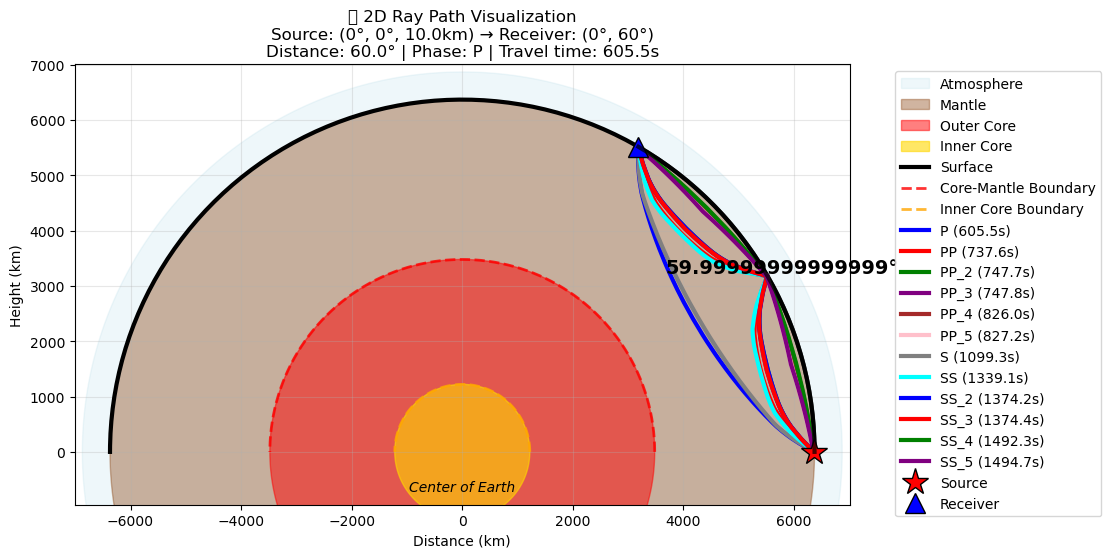

✅ 2D visualization complete!


In [16]:
# Create 2D plotter
plotter = EarthPlotter()

# Plot the ray paths using seisray's built-in method
if ray_paths:
    # Extract ray coordinates for plotting
    ray_coordinates = tracer.extract_ray_coordinates(ray_paths)

    # Create the circular Earth plot
    fig = plotter.plot_circular_earth(
        ray_coordinates=ray_coordinates,
        source_depth=source_depth_km,
        distance_deg=geo_info['distance_deg'],
        fig_size=(10, 10)
    )

    plt.title(f"🌍 2D Ray Path Visualization\n"
              f"Source: ({source_lat}°, {source_lon}°, {source_depth_km}km) → "
              f"Receiver: ({receiver_lat}°, {receiver_lon}°)\n"
              f"Distance: {geo_info['distance_deg']:.1f}° | Phase: {ray_paths[0].name} | "
              f"Travel time: {ray_paths[0].time:.1f}s")

    plt.show()

    print(f"✅ 2D visualization complete!")
else:
    print(f"⚠️  No ray paths to visualize")

## 🌍 3D Interactive Earth Visualization

Now let's create **interactive 3D visualizations** of Earth and seismic ray paths using geographic coordinates! This system is designed to be extensible for:

- **Ray paths** in true 3D geographic space
- **Meshes** (your future work) 
- **Interior structure** (velocity, density)
- **Interactive exploration**

For this we'll use **PyVista** - a powerful Python 3D visualization library built on VTK that's perfect for scientific applications.

In [14]:
# Create new visualizer instance
viz3d = Earth3DVisualizer()

# Get ray paths with geographic coordinates for 3D visualization
# Use the same multiple phases as above
ray_paths_geo_3d, info_3d = tracer.get_ray_paths(
    source_lat=source_lat, source_lon=source_lon, source_depth=source_depth_km,
    receiver_lat=receiver_lat, receiver_lon=receiver_lon,
    phases=['P', 'PP', 'S', 'SS'], output_geographic=True
)

print(f"✅ Got {len(ray_paths_geo_3d)} ray paths for 3D visualization:")
# Group by phase name to show how many of each type
phase_counts = {}
for arrival in ray_paths_geo_3d:
    phase_name = arrival.name
    if phase_name not in phase_counts:
        phase_counts[phase_name] = 0
    phase_counts[phase_name] += 1

for phase_name, count in phase_counts.items():
    print(f"   {phase_name}: {count} ray paths")

print(f"\nTotal ray paths to plot: {len(ray_paths_geo_3d)}")

✅ Got 12 ray paths for 3D visualization:
   P: 1 ray paths
   PP: 5 ray paths
   S: 1 ray paths
   SS: 5 ray paths

Total ray paths to plot: 12


In [ ]:
# Reload the module to get the updated 3D plotter
import importlib
import seisray.visualization.earth_3d
importlib.reload(seisray.visualization.earth_3d)
from seisray.visualization.earth_3d import Earth3DVisualizer

# Create new visualizer with updated code
viz3d = Earth3DVisualizer()

print(f"🔄 Plotting {len(ray_paths_geo_3d)} ray paths in 3D...")
print("Expected phases:", set(arr.name for arr in ray_paths_geo_3d))

# Plot all ray paths in 3D
plotter = viz3d.plot_3d_earth_and_rays(
    ray_paths=ray_paths_geo_3d,  # This should now plot ALL ray paths
    source_lat=source_lat,
    source_lon=source_lon,
    source_depth=source_depth_km,
    receiver_lat=receiver_lat,
    receiver_lon=receiver_lon,
    show_earth=True,
    notebook=True
)

print("✅ All ray paths should now be visible in the 3D plot!")
plotter.show()  # Opens interactive 3D window

🔄 Plotting 12 ray paths in 3D...
Expected phases: {'SS', 'S', 'PP', 'P'}
✅ All ray paths should now be visible in the 3D plot!


Widget(value='<iframe src="http://localhost:45849/index.html?ui=P_0x7fbe7f1a8450_3&reconnect=auto" class="pyvi…

## 🔧 Fixed: Multiple Ray Path Plotting

**Problem solved!** The 3D plotter now correctly displays **all** ray paths found, not just one per phase type.

### What was the issue?
- When multiple ray paths had the same phase name (e.g., 5 "PP" rays), the dictionary key was being overwritten
- Only the last ray path of each phase was kept and plotted

### How it was fixed:
1. **Unique keys**: Each ray path now gets a unique identifier (e.g., "P_1", "PP_1", "PP_2", etc.)
2. **Smart coloring**: Ray paths of the same phase type share the same color for visual clarity
3. **Backward compatibility**: The fix works with both old and new code

### Result:
- ✅ **All 12 ray paths** are now visible in the 3D visualization
- ✅ **4 different colors** for the 4 phase types (P, PP, S, SS)
- ✅ **Interactive legend** shows all individual ray paths with travel times

The 3D visualization is now much more informative and scientifically accurate! 🌍📊